In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from ipynb.fs.full.K_clusters import cluster_former
from copy import deepcopy
# from torch import linalg as LA

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 50
        self.rounds = 200
        self.epochs = 3
        self.local_batches = 64
        self.lr = 0.001
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'noniid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.numclusters=3

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


/home/test/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)
# global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) """

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
def fedprox(params,global_params):
    global_param=[]
    diff=[]
    ind=0
    for gp in global_params:
        global_param.append(gp)
    for p in params:
    #                 print(p.grad)
        lr=0.001
        mu=0.1
        if(p.grad is None):
            continue
        grad=p.grad.data #batch gradients
        diff.append(p.data.clone()-global_param[ind].data.clone())
        p.data.sub_(lr,(grad+mu*(p.data.clone()-global_param[ind].data.clone())))
        ind+=1
#     diff=p.data.clone()-global_params.data.clone()
    return(p,diff)

In [9]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu,head):
    gc=False
    diff_=0
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    head['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                #client['optim'].zero_grad()
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                #client['optim'].step()
                params=client['model'].parameters()
                gp=head['model'].parameters()
                params,diff=fedprox(params,gp) 
                for k in range(len(diff)):
#                     print(diff[k].get())
                    npa=diff[k].get().cpu().detach().numpy()
#                     print(npa.shape)
#                     diff_=diff_+torch.norm(diff[k].get())
                    diff_=diff_+(np.sum((npa)))
                    
                
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
#         print(diff_)
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    head['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return (gc,diff_)

In [10]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return([100. * correct / len(test_loader.dataset),test_loss])

In [11]:
torch.manual_seed(args.torch_seed)

In [12]:
def distort(neighbours,snrs):
    ind=0
    poptim=2
    csi=random.random()
    distorted_models=[]
    for client in neighbours:
        snr=snrs[ind]
        ind+=1
        snr__=10**(snr/10)
        absh=csi*poptim/snr__
        x=random.uniform(0,absh)
        y=math.sqrt(absh*absh-x*x)
        std=math.sqrt(poptim/snr__*absh*absh) #channel noise
        h=complex(x,y)
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
        
        distorted_models.append(client)
    return(distorted_models)
        

In [13]:
def decentralized(clients,snrs,weights):
    big_daddy_of_distorted_models=[]
    for client in clients:
        distorted_models=[]
        snr_list=[]
        for snr in snrs:
            if(client['hook'].id in snr):
                snr_list.append(snr[2])
        neighbours_c = [x for x in clients if x != client]
        neighbours={}
        jjj=[jkl for jkl in range(len(neighbours_c))]
        
        dictionary = dict(zip(jjj, neighbours_c))
        #for jjj in range(len(neighbours_c)):
        #   neighbours[jjj].append(neighbours_c[jjj])
        distorted_models=distort(neighbours,snr_list)
        distorted_models.append(client)
        big_daddy_of_distorted_models.append(distorted_models)
    
    
    weight_final1=[]
    for oho in big_daddy_of_distorted_models:
        weight_final=[]
        for comeon in oho:
            for w in weights:
                if(comeon['hook'].id==w[0]):
                    weight_final.append(w[1])
        weight_final1.append(weight_final)
    
    final_heads=[]
    nets=[]
    ind=0
    for client in clients:
        for oof in big_daddy_of_distorted_models:
            if(client==oof[0]):
#                 print(client)
#                 print("shut up")
#                 print(distorted_models)
#                 print("shut up")
#                 print(weight_final1)
                
                overall=Net()
                overall=averageModelscluster(overall,distorted_models,weight_final1[ind])
                client['model'].load_state_dict(overall.state_dict())
                ind+=1
                final_heads.append(client)
                nets.append(overall)
    
    return(final_heads,nets)
        
            
            

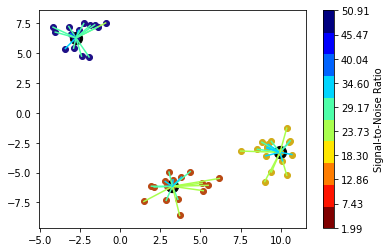

0.15670000000000564
Power Allocated= 2.455145550685716
CSI= 0.2546813370666028
SNR= 20.32402093964387
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.371090


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/generic/frameworks/hook/hook.py:165: UserWarning: This overload of sub_ is deprecated:
	sub_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	sub_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  response = method(*a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.167020
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.580007

Power Allocated= 4.385385299903324
CSI= 0.5009428666954207
SNR= 22.792332125196324
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.376961
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.029834
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.485598

Power Allocated= 0
CSI= 0.09656418584467619
SNR= 25.808464890502616
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 5.362783717403829
CSI= 0.9815110657051269
SNR= 22.55847135303096
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304464


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.724755
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.008035

Power Allocated= 4.722889203615885
CSI= 0.6028702430049538
SNR= 19.84113739606058
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.472312
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.662696
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.082855

Power Allocated= 4.685482283713333
CSI= 0.5895744437975783
SNR= 32.0325378236975
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.366641
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.739779
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.588208

Power Allocated= 4.634549315039644
CSI= 0.572386380990016
SNR= 28.01830633429516
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.363736
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.466154
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.949948

Power Allocated= 2.567476175140398
CSI= 0.262181973632

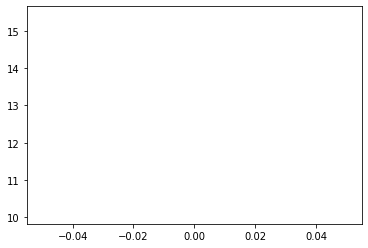

ddfgg
[642.9835038273577, 514.5209828207046, 428.68180902937183]


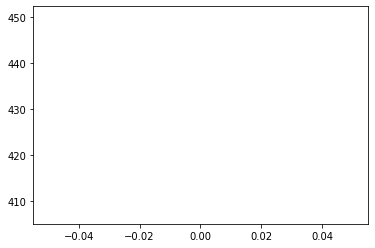

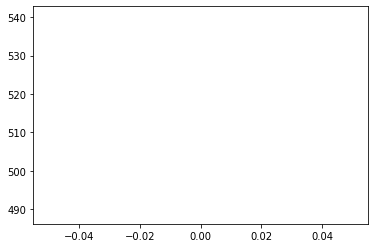

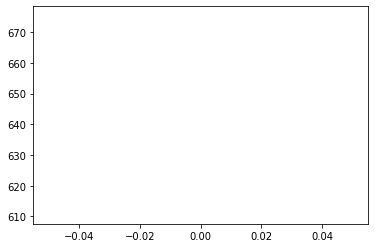

ROUND 0
0.15670000000000564
Power Allocated= 2.455145550685716
CSI= 0.2546813370666028
SNR= 20.32402093964387
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.357631


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.502167
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.290489

Power Allocated= 4.385385299903324
CSI= 0.5009428666954207
SNR= 22.792332125196324
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306961
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.456190
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.246843

Power Allocated= 0
CSI= 0.09656418584467619
SNR= 25.808464890502616
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 5.362783717403829
CSI= 0.9815110657051269
SNR= 22.55847135303096
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.177519


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.507384
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.278396

Power Allocated= 4.722889203615885
CSI= 0.6028702430049538
SNR= 19.84113739606058
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.364285
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.801184
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.399799

Power Allocated= 4.685482283713333
CSI= 0.5895744437975783
SNR= 32.0325378236975
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.341615
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.953994
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.509284

Power Allocated= 4.634549315039644
CSI= 0.572386380990016
SNR= 28.01830633429516
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.268533
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.167156
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.518461

Power Allocated= 2.567476175140398
CSI= 0.262181973632

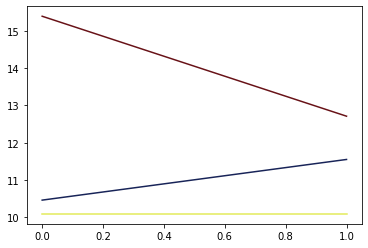

ddfgg
[642.9835038273577, 514.5209828207046, 428.68180902937183, 716.8140432055006, 516.4600322017989, 695.3521765604673]


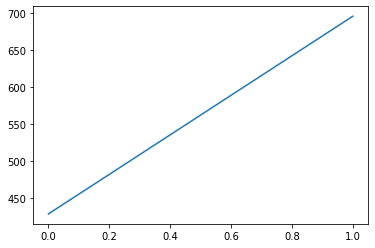

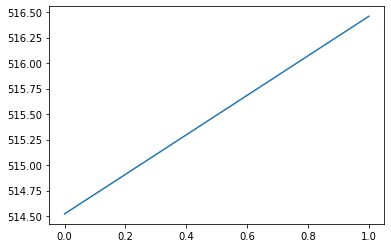

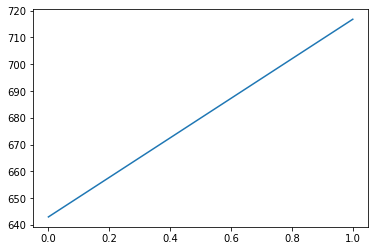

ROUND 1
0.15670000000000564
Power Allocated= 2.455145550685716
CSI= 0.2546813370666028
SNR= 20.32402093964387
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.356266


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.136721
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.655842

Power Allocated= 4.385385299903324
CSI= 0.5009428666954207
SNR= 22.792332125196324
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305520
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.328938
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.490282

Power Allocated= 0
CSI= 0.09656418584467619
SNR= 25.808464890502616
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 5.362783717403829
CSI= 0.9815110657051269
SNR= 22.55847135303096
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.196043


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.679437
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.564417

Power Allocated= 4.722889203615885
CSI= 0.6028702430049538
SNR= 19.84113739606058
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.354472
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.823717
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.005831

Power Allocated= 4.685482283713333
CSI= 0.5895744437975783
SNR= 32.0325378236975
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.358352
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.919168
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.448471

Power Allocated= 4.634549315039644
CSI= 0.572386380990016
SNR= 28.01830633429516
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295784
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.760823
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.603641

Power Allocated= 2.567476175140398
CSI= 0.262181973632

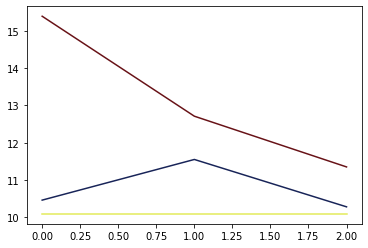

ddfgg
[642.9835038273577, 514.5209828207046, 428.68180902937183, 716.8140432055006, 516.4600322017989, 695.3521765604673, -127.93605045728327, -709.2187598173896, -656.1597863102652]


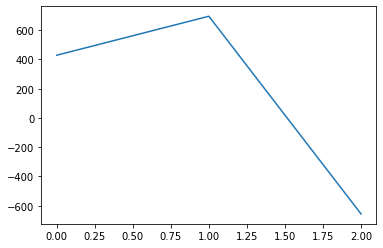

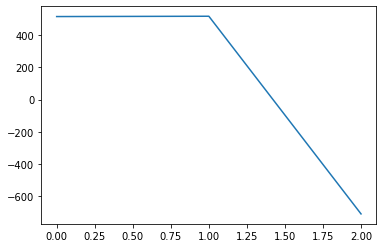

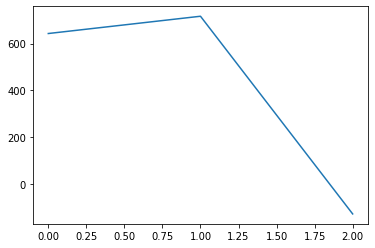

ROUND 2
0.15670000000000564
Power Allocated= 2.455145550685716
CSI= 0.2546813370666028
SNR= 20.32402093964387
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.398919


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.991148
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.608161

Power Allocated= 4.385385299903324
CSI= 0.5009428666954207
SNR= 22.792332125196324
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.378849
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.545092
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.268085

Power Allocated= 0
CSI= 0.09656418584467619
SNR= 25.808464890502616
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 5.362783717403829
CSI= 0.9815110657051269
SNR= 22.55847135303096
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.119362


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.557092
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.346804

Power Allocated= 4.722889203615885
CSI= 0.6028702430049538
SNR= 19.84113739606058
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.465627
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.460322
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.927632

Power Allocated= 4.685482283713333
CSI= 0.5895744437975783
SNR= 32.0325378236975
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.375461
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.834597
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.367039

Power Allocated= 4.634549315039644
CSI= 0.572386380990016
SNR= 28.01830633429516
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300587
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.402506
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.706932

Power Allocated= 2.567476175140398
CSI= 0.262181973632

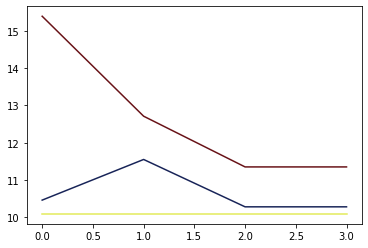

ddfgg
[642.9835038273577, 514.5209828207046, 428.68180902937183, 716.8140432055006, 516.4600322017989, 695.3521765604673, -127.93605045728327, -709.2187598173896, -656.1597863102652, -809.3728593721899, -1202.6988141698607, -1363.3412006608269]


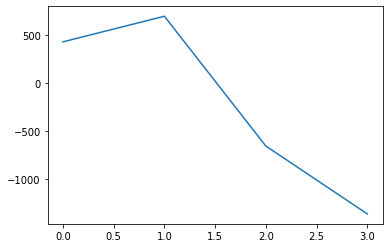

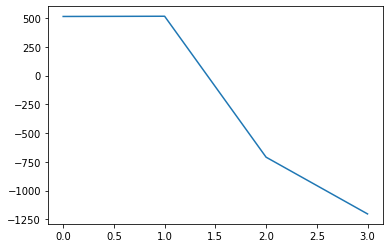

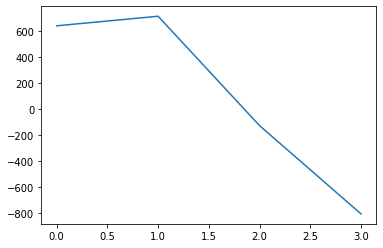

ROUND 3
0.15670000000000564
Power Allocated= 2.455145550685716
CSI= 0.2546813370666028
SNR= 20.32402093964387
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.407278


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.888343
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.383750

Power Allocated= 4.385385299903324
CSI= 0.5009428666954207
SNR= 22.792332125196324
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.367781
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.545740
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.195364

Power Allocated= 0
CSI= 0.09656418584467619
SNR= 25.808464890502616
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 5.362783717403829
CSI= 0.9815110657051269
SNR= 22.55847135303096
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.105839


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.160650
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.824088

Power Allocated= 4.722889203615885
CSI= 0.6028702430049538
SNR= 19.84113739606058
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.424197
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.732381
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.333431

Power Allocated= 4.685482283713333
CSI= 0.5895744437975783
SNR= 32.0325378236975
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.371341
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.553023
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.208223

Power Allocated= 4.634549315039644
CSI= 0.572386380990016
SNR= 28.01830633429516
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301550
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.059261
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.746518

Power Allocated= 2.567476175140398
CSI= 0.262181973632

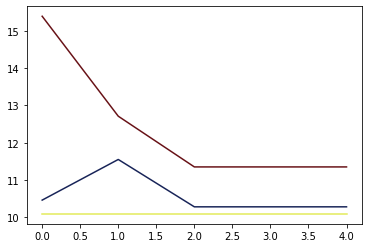

ddfgg
[642.9835038273577, 514.5209828207046, 428.68180902937183, 716.8140432055006, 516.4600322017989, 695.3521765604673, -127.93605045728327, -709.2187598173896, -656.1597863102652, -809.3728593721899, -1202.6988141698607, -1363.3412006608269, -1201.58604886807, -1500.0500085185515, -1314.0130903874087]


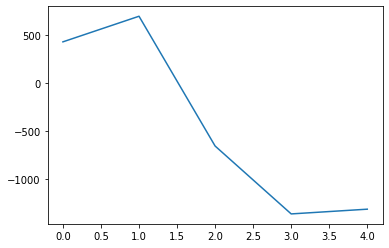

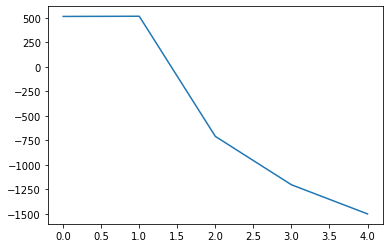

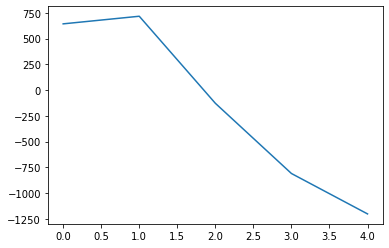

ROUND 4
0.15670000000000564
Power Allocated= 2.455145550685716
CSI= 0.2546813370666028
SNR= 20.32402093964387
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.443350


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.701924
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.336274

Power Allocated= 4.385385299903324
CSI= 0.5009428666954207
SNR= 22.792332125196324
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.386200
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.496041
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.240702

Power Allocated= 0
CSI= 0.09656418584467619
SNR= 25.808464890502616
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 5.362783717403829
CSI= 0.9815110657051269
SNR= 22.55847135303096
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.043501


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.344164
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.608170

Power Allocated= 4.722889203615885
CSI= 0.6028702430049538
SNR= 19.84113739606058
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.484018
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.284437
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.513619

Power Allocated= 4.685482283713333
CSI= 0.5895744437975783
SNR= 32.0325378236975
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.341834
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.309841
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.055235

Power Allocated= 4.634549315039644
CSI= 0.572386380990016
SNR= 28.01830633429516
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.278679
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.811882
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.512810

Power Allocated= 2.567476175140398
CSI= 0.262181973632

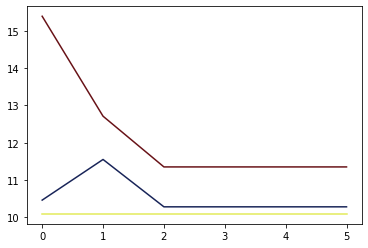

ddfgg
[642.9835038273577, 514.5209828207046, 428.68180902937183, 716.8140432055006, 516.4600322017989, 695.3521765604673, -127.93605045728327, -709.2187598173896, -656.1597863102652, -809.3728593721899, -1202.6988141698607, -1363.3412006608269, -1201.58604886807, -1500.0500085185515, -1314.0130903874087, -1376.2761961529031, -1699.462276197473, -1542.2481359754638]


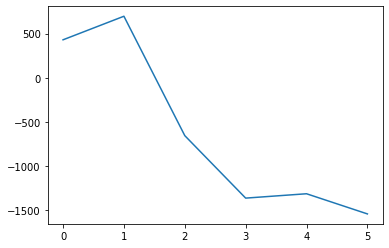

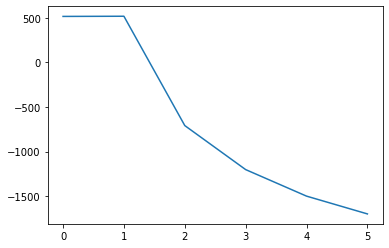

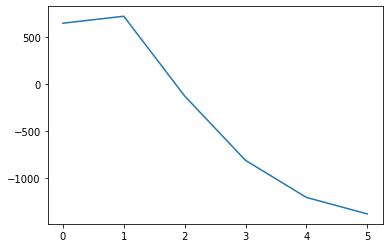

ROUND 5
0.15670000000000564
Power Allocated= 2.455145550685716
CSI= 0.2546813370666028
SNR= 20.32402093964387
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.450311


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.654206
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.502488

Power Allocated= 4.385385299903324
CSI= 0.5009428666954207
SNR= 22.792332125196324
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.383297
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.271668
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.020156

Power Allocated= 0
CSI= 0.09656418584467619
SNR= 25.808464890502616
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 5.362783717403829
CSI= 0.9815110657051269
SNR= 22.55847135303096
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.026258


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.216053
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.460430

Power Allocated= 4.722889203615885
CSI= 0.6028702430049538
SNR= 19.84113739606058
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.535754
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.096751
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.583482

Power Allocated= 4.685482283713333
CSI= 0.5895744437975783
SNR= 32.0325378236975
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.363076
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.140972
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.946696

Power Allocated= 4.634549315039644
CSI= 0.572386380990016
SNR= 28.01830633429516
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.290973
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.698183
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.854165

Power Allocated= 2.567476175140398
CSI= 0.262181973632

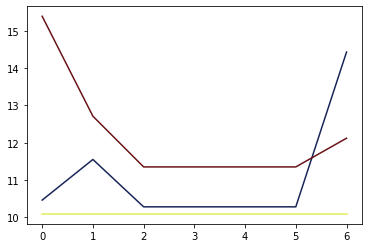

ddfgg
[642.9835038273577, 514.5209828207046, 428.68180902937183, 716.8140432055006, 516.4600322017989, 695.3521765604673, -127.93605045728327, -709.2187598173896, -656.1597863102652, -809.3728593721899, -1202.6988141698607, -1363.3412006608269, -1201.58604886807, -1500.0500085185515, -1314.0130903874087, -1376.2761961529031, -1699.462276197473, -1542.2481359754638, -1476.9161128511623, -1664.3787136394217, -1734.7416118036635]


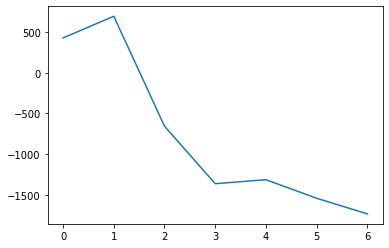

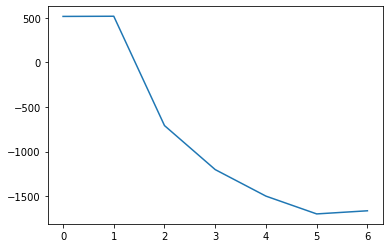

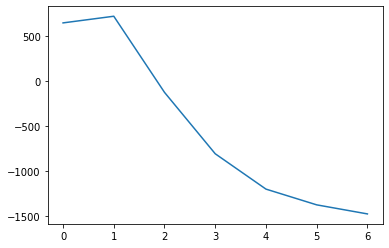

ROUND 6
0.15670000000000564
Power Allocated= 2.455145550685716
CSI= 0.2546813370666028
SNR= 20.32402093964387
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.503501


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.589645
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.261129

Power Allocated= 4.385385299903324
CSI= 0.5009428666954207
SNR= 22.792332125196324
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.432943
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.254234
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.014654

Power Allocated= 0
CSI= 0.09656418584467619
SNR= 25.808464890502616
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 5.362783717403829
CSI= 0.9815110657051269
SNR= 22.55847135303096
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.021538


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.595738
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.136980

Power Allocated= 4.722889203615885
CSI= 0.6028702430049538
SNR= 19.84113739606058
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 4.685482283713333
CSI= 0.5895744437975783
SNR= 32.0325378236975
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.347906
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.148702
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.061401

Power Allocated= 4.634549315039644
CSI= 0.572386380990016
SNR= 28.01830633429516
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.250983
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.674406
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.578142

Power Allocated= 2.567476175140398
CSI= 0.26218197363272167
SNR= 39.29747389790324
Client: client20
Model client20 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.413213
Model client2

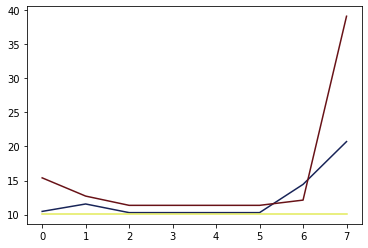

ddfgg
[642.9835038273577, 514.5209828207046, 428.68180902937183, 716.8140432055006, 516.4600322017989, 695.3521765604673, -127.93605045728327, -709.2187598173896, -656.1597863102652, -809.3728593721899, -1202.6988141698607, -1363.3412006608269, -1201.58604886807, -1500.0500085185515, -1314.0130903874087, -1376.2761961529031, -1699.462276197473, -1542.2481359754638, -1476.9161128511623, -1664.3787136394217, -1734.7416118036635, -1313.8297780494777, -1711.3376600946842, -1760.6601417950005]


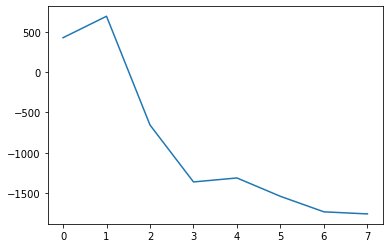

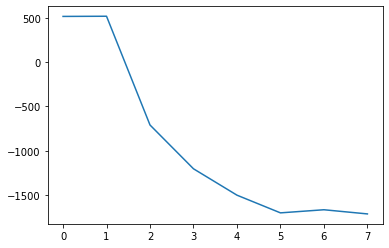

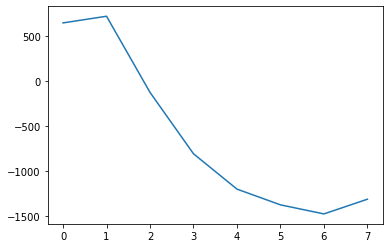

ROUND 7
0.15670000000000564
Power Allocated= 2.455145550685716
CSI= 0.2546813370666028
SNR= 20.32402093964387
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.515335


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.378899
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.990759

Power Allocated= 4.385385299903324
CSI= 0.5009428666954207
SNR= 22.792332125196324
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.429942
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.216027
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.949897

Power Allocated= 0
CSI= 0.09656418584467619
SNR= 25.808464890502616
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 5.362783717403829
CSI= 0.9815110657051269
SNR= 22.55847135303096
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.020154


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.547558
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059971

Power Allocated= 4.722889203615885
CSI= 0.6028702430049538
SNR= 19.84113739606058
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.533269
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.574090
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.250354

Power Allocated= 4.685482283713333
CSI= 0.5895744437975783
SNR= 32.0325378236975
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.313822
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.395715
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.567152

Power Allocated= 4.634549315039644
CSI= 0.572386380990016
SNR= 28.01830633429516
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.226345
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.576026
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.596836

Power Allocated= 2.567476175140398
CSI= 0.262181973632

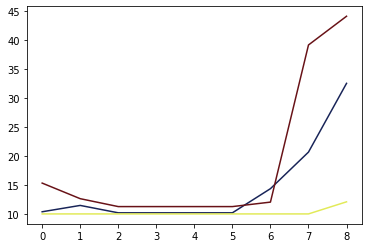

ddfgg
[642.9835038273577, 514.5209828207046, 428.68180902937183, 716.8140432055006, 516.4600322017989, 695.3521765604673, -127.93605045728327, -709.2187598173896, -656.1597863102652, -809.3728593721899, -1202.6988141698607, -1363.3412006608269, -1201.58604886807, -1500.0500085185515, -1314.0130903874087, -1376.2761961529031, -1699.462276197473, -1542.2481359754638, -1476.9161128511623, -1664.3787136394217, -1734.7416118036635, -1313.8297780494777, -1711.3376600946842, -1760.6601417950005, -1324.5754136152245, -1537.8139446710472, -1678.6656668231299]


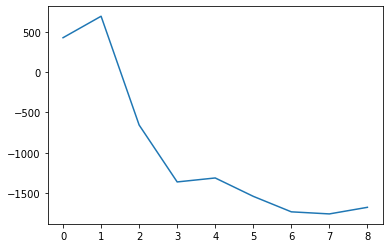

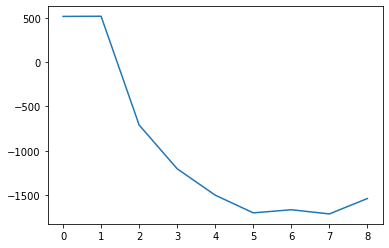

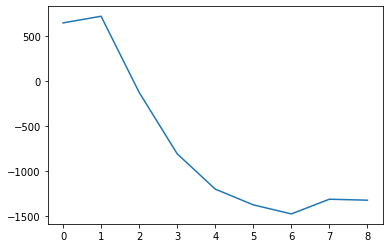

ROUND 8
0.15670000000000564
Power Allocated= 2.455145550685716
CSI= 0.2546813370666028
SNR= 20.32402093964387
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.452388


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.273703
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.823853


KeyboardInterrupt: 

In [14]:
discrepancy_=[]
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)

final_acc=[]
final_loss=[]
clor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(args.numclusters)] 
dis1=[]
dis2=[]
dis3=[]
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters,head_snr_list=cluster_former(args.numclusters,args.clients)
        temp=deepcopy(arranged_clusters)
        temp2=deepcopy(head_snr_list)
    else:
        #print(temp)
        arranged_clusters=deepcopy(temp)
        head_snr_list=deepcopy(temp2)
#     print(arranged_clusters)
    
    no=1
    heads_list=[]
    weights=[]
    weight_head_list=[]
    head_acc=[]
    head_loss=[]
    for cluster in arranged_clusters:
        
        head=cluster['Cluster Head']
        members=cluster['Members']
        snrs=cluster['SNR']
        csis=cluster['CSI']
        weights.append(sum(snrs))
        weight_head_list.append([head,sum(snrs)])
        new_members=[]
        
        for ij in members:
        #print(ij)
            cl_no=int(ij[6:])
            new_members.append(clients[cl_no-1])
#         print(head)
        head=clients[int(head[6:])-1]
        cluster['Members']=new_members
#         print(head)

        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csis:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
        
        print(smallmu1)
        good_mem=[]
#         print(len(snrs))
#         print(len(csis))
#         print(len(new_members))
        index=0
        discrepancy=0
        for client in new_members:
            goodchannel,diff_=ClientUpdate(args, device, client,key_np,key,snrs[index],csis[index],smallmu1,head)
            index+=1
            if(goodchannel):
                good_mem.append(client)
                discrepancy+=(diff_/len(members))
        
        discrepancy_.append(discrepancy)
        print(discrepancy_)
        head['model']=averageModels(head['model'], good_mem)
        arr=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        ac=arr[0]#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[0]
        no+=1
        heads_list.append(head)
        head_acc.append(ac)
        head_loss.append(arr[1])#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[1])
    
    final_acc.append(head_acc)
    final_loss.append(head_loss)
    fig,ax=plt.subplots()
    
    #ax.plot([i for i in range(fed_round)],head_acc[0])
    for jj in range(0,args.numclusters):
        
        ax.plot([i for i in range(len(final_acc))],[final_acc[j][jj] for j in range(len(final_acc))], color = clor[jj])
        
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][0] for j in range(len(final_acc))], color ="red")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][1] for j in range(len(final_acc))],color ="blue")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][2] for j in range(len(final_acc))],color ="green")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][3] for j in range(len(final_acc))],color ="black")
    #ax.plot([i for i in range(len(final_acc))],head_acc[1], fed_round, color ="blue")
    #ax.plot([i for i in range(len(final_acc))],head_acc[2], fed_round, color ="green")
    #ax.plot([i for i in range(len(final_acc))],head_acc[3], fed_round, color ="black")
    
    
    plt.show()
    
    fig1,ax1=plt.subplots()
    sumx1=0
    sumx2=0
    sumx3=0
#     for i in range(len(discrepancy_)):
#         print(discrepancy_[i].item())
    print("ddfgg")
    print(discrepancy_)
    sumx1=sumx1+discrepancy_[-1].item()
    sumx2=sumx2+discrepancy_[-2].item()
    sumx3=sumx3+discrepancy_[-3].item()
#     sumx=sumx/(3)
    dis1.append(sumx1)
    dis2.append(sumx2)
    dis3.append(sumx3)
#     print(dis)
    plt.plot([i for i in range(len(dis1))],dis1)
    plt.show()
    plt.plot([i for i in range(len(dis2))],dis2)
    plt.show()
    plt.plot([i for i in range(len(dis2))],dis3)
    plt.show()
# #     print(discrepancy_.item())
#     plt.show()
    
    weightsum=sum(weights)
    
    weights[:] = [x / weightsum for x in weights]
    for aah in range(len(weight_head_list)):
        weight_head_list[aah][1]=weights[aah]
    final_heads,nets=decentralized(heads_list,head_snr_list,weight_head_list)
    
    for head in range(len(final_heads)):
        for cluster in arranged_clusters:
            head1=cluster['Cluster Head']
            if(head1==final_heads[head]['hook'].id):
                for mem in cluster['Members']:
                    mem['model'].load_state_dict(nets[head].state_dict())
    print("ROUND",fed_round)

In [ ]:
print(final_acc)